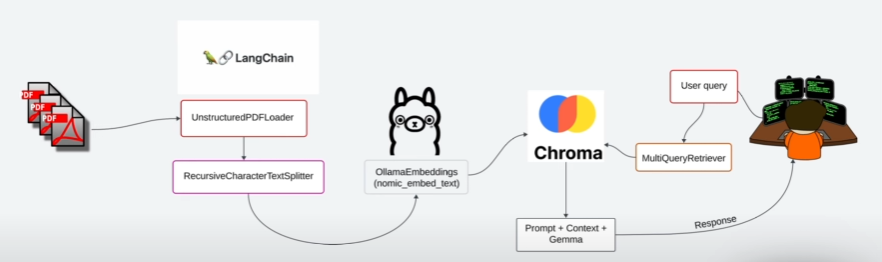

In [1]:
!pip install -q langchain unstructured[all-docs] faiss-cpu
!ollama pull llama3
!ollama pull nomic-embed-text

DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
pulling manifest ⠋ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠴ pulling manifest ⠴ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠇ pulling manifest ⠋ pulling manifest ⠋ pulling manifest ⠹ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠧ pulling manifest ⠏ pulling manifest 
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB                         
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB                         
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B                         
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B                         
pulling 3f8eb4

In [1]:
import os
from unstructured.partition.pdf import partition_pdf
from unstructured.chunking.title import chunk_by_title
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.chat_models import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

C:\Users\AKHILESH\AppData\Roaming\Python\Python312\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4
C:\Users\AKHILESH\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  preprocess pdfs inside pdfs directory (whatever PDFs you like)
def preprocess_pdfs(directory):
  elements = []
  for root, _, files in os.walk(directory):
    for file in files:
        if file.endswith(".pdf"):
            elems = partition_pdf(filename=os.path.join(root,file), languages=['eng'], strategy="fast")
            elements.extend(elems)
  return elements

In [3]:
data=preprocess_pdfs("books")

## Vector Embedding

In [4]:
!ollama list

NAME                       ID              SIZE      MODIFIED    
llama2:latest              78e26419b446    3.8 GB    4 weeks ago    
nomic-embed-text:latest    0a109f422b47    274 MB    4 weeks ago    
llama3:latest              365c0bd3c000    4.7 GB    4 weeks ago    
dolphin-mixtral:latest     cfada4ba31c7    26 GB     5 weeks ago    
llama3.2:latest            a80c4f17acd5    2.0 GB    5 weeks ago    


In [5]:
# Split and Chunk
chunked_elements = chunk_by_title(data,max_characters=1000,overlap=100)

documents = []
for element in chunked_elements:
    metadata = element.metadata.to_dict()
    documents.append(Document(page_content=element.text,
                              metadata=metadata))


In [6]:
# Add to vector database
db = FAISS.from_documents(documents, OllamaEmbeddings(model="nomic-embed-text",show_progress=True))

OllamaEmbeddings: 100%|██████████| 55/55 [02:18<00:00,  2.51s/it]


## Retrieval

In [7]:
from langchain.retrievers import MultiQueryRetriever
from langchain.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [10]:
local_model="llama3.2"
llm=ChatOllama(model=local_model)

In [93]:
# llm=ChatGroq(model='llama3-groq-8b-8192-tool-use-preview')

In [11]:
QUERY_PROMPT=PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five different versions of the given user question to retrieve relevant documents from a vector database. By generating multiple perspectives on the user question, your goal is to help the user to overcome some of the limitations of the distance based similarity search. Provide these alternative questions seperated by newlines.
    Original questiooon: {question}
""",
)

In [12]:
retriever = MultiQueryRetriever.from_llm(
    db.as_retriever(),
    llm,
    prompt=QUERY_PROMPT
)

In [13]:
# RAG prompt
template="""Answer the question based ONLY on the following context:
{context}
Question: {question}
"""

In [14]:
prompt=ChatPromptTemplate.from_template(template)

In [15]:
model=(
    {"context":retriever,"question":RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [16]:
model.invoke(input(""))

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


'The attention layer, also known as the Self-Attention mechanism, is a key component of the Transformer architecture in deep learning. It was introduced by Vaswani et al. in their 2017 paper "Attention Is All You Need".\n\nIn traditional recurrent neural networks (RNNs), information flows through time sequentially, and each step depends on the previous one. In contrast, the attention mechanism allows the model to weigh the importance of different input elements for a given output element. This is done by calculating the similarity between all pairs of input elements and applying weights based on these similarities.\n\nThe attention layer takes three inputs:\n\n1. Query (Q): represents the context or information that we want to focus on.\n2. Key (K): represents the information or features that we have access to.\n3. Value (V): represents the actual values or data that we want to use to compute the attention weights.\n\nThe attention layer computes three outputs:\n\n1. Attention weights 